In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import random 
from random import randint

In [2]:
class Room(object):
    
    def __init__(self, width=10, length=10, num_items=3, random_switch=0.1, verbose=False):
        '''
        Inputs:

            length (int) The length of the room. Corresponds to the number of
              arrays in the nested array, used to model the room. Default: 10.
              
            width (int) The width of the room. Corresponds to the number of
              elements in each array of the nested array, used to model the room.
              Default: 10.
            
            num_items (int) The number of furniture items in the room. Default: 3.
            
            random_switch (float) The fraction of time when robot, following the
              straight walk strategy will make a random direction switch. Default: 0.1.
              
            verbose (bool) If set True, configurations of failed attemps to set up
              the room are printed. Default: False.
        '''
        
        self.length = length
        self.width = width
        self.num_tiles = width*length
        self.num_items = num_items
        self.random_switch = random_switch
        self.verbose = verbose
        
        # Initialize a room with various levels of dust
        self.room = np.random.random(size=(self.length, self.width))
        
        # Step/efficiency trackers 
        self.steps = 0
        self.clean = 0

    def room_setup(self):
        '''Sets up the room.'''
        
        if self.num_items > self.num_tiles-1: # Leaving one spot for Roomba
            raise Exception('The room if full!')
        
        # Set the objects
        for _ in range(self.num_items): 
            x = randint(0,self.length-1)
            y = randint(0,self.width-1)
            
            while (self.room[x,y] == 2):
                x = randint(0,self.length-1)
                y = randint(0,self.width-1)
            self.room[x,y] = 2
        
        self.robot = Robot(room=self) # Creating a Robot attribute, an object of class Robot
        self.set_roomba()
        temp = self.next_position(current_position=self.robot.roomba_location)
        
        # Accounts for cases where Roomba is "trapped" in-between furniture items.
        if temp is None:
            if self.verbose:
                print('See below the configuration in which Roomba got stuck. Resetting the room...')
                self.show() # Showing configurations in which Roomba got trapped.
            self.room = np.random.random(size=(self.length, self.width)) # Resetting the room.
            self.room_setup() # Recursively calling the function, until fixed.
    
    def set_roomba(self):
        free = np.where(self.room<2)
        spot = randint(0,len(free))
        self.room[free[0][spot], free[1][spot]] = 1.5
        self.robot.initial_location = [free[0][spot], free[1][spot]] # will never be changed
        self.robot.previous_pos = [free[0][spot], free[1][spot]] # will be updated
        self.robot.roomba_location = np.where(self.room==1.5)
        # in the first iteration, previous_pos = roomba_location

    def update_counters(self, next_position):
        self.steps += 1
        if self.room[next_position] != 0:
            self.clean +=1
    
    def next_position(self, current_position, previous_pos = None):
        '''
        Determines the next step of the robot randomly by evaluating
        cells in the Von Neumann neighborhood. If called
        within a straight walk strategy, ensures that the direction 
        from which Roomba just came is not chosen as the next step.
        Only if there is no other valid/possible next step will 
        it send Roomba back where it came from. 
        
        '''
        i, x = current_position

        # Generate four adjacent tiles
        # This if only executes in the straight_walk strategy
        if previous_pos:
            options = [[i,x+1], [i,x-1], [i+1,x], [i-1,x]] # generate all options
            options.remove(list(previous_pos)) # exclude previous position
            random.shuffle(options) # shuffle options
            
            # append previous position (will be tried if all other fail)
            options.append(list(previous_pos))
            
        else:
            options = [[i,x+1], [i,x-1], [i+1,x], [i-1,x]]
            random.shuffle(options)

        # Check whether adjancent tile is a valid move.
        for option in options:
            try:
                if self.room[option] == 2:
                    continue
                if (option[0]==-1 or option[0]==self.length) or (option[1]==-1 or option[1]==self.width):
                    continue  
                return option
            except IndexError:
                pass  # try next
            
    def random_walk(self):
        '''
        This function enables Roomba to execute a random walk.
        '''
        
        current_position = self.robot.roomba_location # [i,x]
        next_position = self.next_position(current_position=current_position)
        
        try:
            self.update_counters(next_position)
        except ValueError:
            print(self.robot.roomba_location, current_position, next_position)
            self.show()
            raise Exception('The roomba is mad!!!1')
        
        self.room[next_position] = 1.5
        self.room[current_position] = 0
        self.robot.roomba_location = next_position
    
    def straight_pos(self, prev_pos, current_pos):
        '''Determines the next step of the robot that would ensure
        its straight walk behavior. The memory propoerty of the robot
        enables such behavior. Once it faces an obstacle, the robot
        changes the direction randomly. It only bounces back in the same
        direction it came back from if the rest of the options are invalid,
        e.g. when it is trapped in a "pocket" between
        two walls and an obstacle.'''
        
        m, n = prev_pos
        i, x = current_pos
        next_pos = 0
        
        if m==i: # stayed in the same row
            if x==n-1: # came from the right
                next_pos = [i,x-1]
            else: # came from the left
                next_pos = [i,x+1]
        else: # switched rows
            if i==m+1: # came from above
                next_pos = [i+1,x]
            else: # came from below
                next_pos = [i-1,x]
        
        # Check the validity of the next_position.
        # If not valid, pick the next position randomly.
        try:
            if self.room[next_pos] == 2:  # obstacle
                return self.next_position(current_pos, prev_pos) # returns the next step, chosen randomly
            elif (next_pos[0]==-1 or next_pos[1]==-1):
                return self.next_position(current_pos, prev_pos) # returns the next step, chosen randomly
            else:
                return next_pos
        except IndexError:
            return self.next_position(current_pos, prev_pos) # if out of bounds, return random next position 
    
    def straight_walk(self):       
        '''
        This function enables Roomba to execute a straight walk.
        To prevent Roomba from falling into a wall-following pattern,
        the straight walk step is replaced with a random walk step
        a certain percentage of the time. By default, the switch
        happens 10% of the time.
        '''

        prev_pos = self.robot.previous_pos
        self.robot.previous_pos = self.robot.roomba_location
        
        # Random change of direction to avoid exclusively wall-following behavior.
        if random.uniform(0, 1) > self.random_switch: 
            next_position = self.straight_pos(prev_pos, self.robot.roomba_location) # gives the next position to go straight
        else: 
            next_position = self.next_position(self.robot.roomba_location, prev_pos)
        
        self.update_counters(next_position)
        self.room[next_position] = 1.5
        self.room[self.robot.roomba_location] = 0
        self.robot.roomba_location = next_position
        
    def pick_direction(self): # pick direction + move 1 step 
        next_position = self.next_position(self.robot.roomba_location)
        self.robot.previous_pos = self.robot.roomba_location
        self.update_counters(next_position)
        self.room[self.robot.roomba_location] = 0
        self.room[next_position] = 1.5
        self.robot.roomba_location = next_position 
    
    def show(self):
        plt.imshow(self.room, cmap='YlOrBr', vmin=0, vmax=2)
        return plt.show()

In [ ]:
class Robot(object):
    
    def __init__(self, room=None):
        '''
        Inputs:

            room (object) The object of class Room that will enable 
               the update of internal memory of the Robot class object.
               Default: None.
              
        '''
        self.roomba_location = np.where(room.room==1.5)
        self.initial_location = 0
        self.previous_pos = 0
        room.robot = self

## Analysis & Visualization

In the visualization, the obstacles are dark brown and Roomba is light-brown/red. The dust is of different shades of orange, representing various levels of dirtiness. 

Image of the original room set-up:


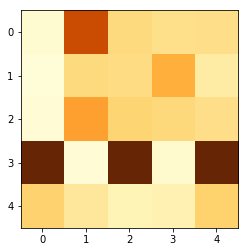

Image after picked the intial direction and took the 1st step:


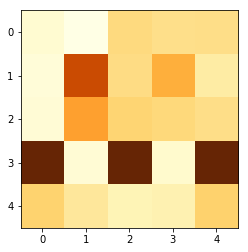

Image after a straight walk step: 1 , overall step: 2


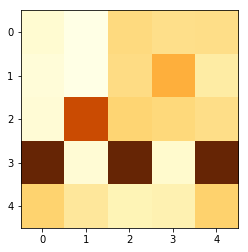

Image after a straight walk step: 2 , overall step: 3


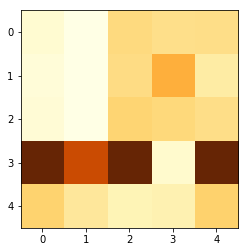

Image after a straight walk step: 3 , overall step: 4


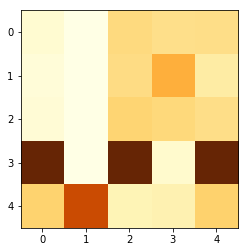

In [4]:
# Setting random seeds to fix room configurations;
# used for debugging. 

# np.random.seed(205)
# random.seed(205)

r_tester = Room(width=5, length=5, random_switch=0.1)
r_tester.room_setup() 
print('Image of the original room set-up:')
r_tester.show()

r_tester.pick_direction()
print('Image after picked the intial direction and took the 1st step:')
r_tester.show()
    
for i in range(3):
    r_tester.straight_walk()
    print('Image after a straight walk step:', i+1, ', overall step:', i+2 )
    r_tester.show()

## Monte Carlo Simulation

### Straight Walk: Optimal Switch Percentage

In [46]:
percentages = np.arange(0.1, 1.1, 0.1)

all_counts = []
count = []

for percentage in percentages:
    for i in range(1000):
        r = Room(width=10, length=10, random_switch = percentage)
        r.room_setup()
        
        r.pick_direction()
        while r.clean/(r.num_tiles-r.num_items-1) <= 0.95:
            r.straight_walk()
        count.append((1-r.clean/r.steps))
    all_counts.append(np.mean(count))

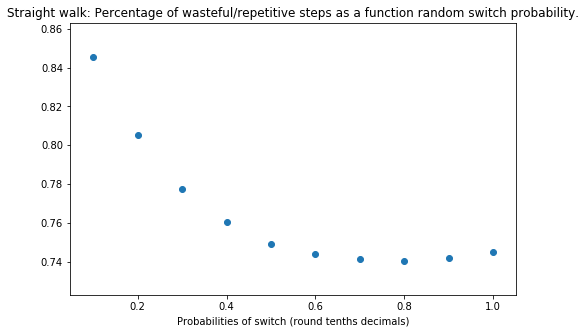

Minimum number of wasteful steps is achieved with the probability of direction switch equal to:  0.8


In [128]:
plt.figure(figsize=(8, 5))
plt.scatter(percentages,all_counts)
plt.title('Straight walk: Percentage of wasteful/repetitive steps as a function random switch probability.')
plt.xlabel('Probabilities of switch (round tenths decimals)')
plt.show()

ind = np.where(all_counts == np.min(all_counts))
optimal_p_switch = float(percentages[ind])
print('Minimum number of wasteful steps is achieved with the probability of direction switch equal to: ',
      optimal_p_switch)

### Efficiency Measure 1: Time  

In [92]:
count_steps_rand = []

for x in range(1000):
    r = Room(width=10, length=10, verbose=True)
    r.room_setup()
    
    while r.clean/(r.num_tiles-r.num_items-1) <= 0.95:
        r.random_walk()
    count_steps_rand.append(r.steps)

In [120]:
count_steps_straight = []

for x in range(1000):
    r = Room(width=10, length=10, random_switch=optimal_p_switch, verbose=True)
    r.room_setup()
    
    r.pick_direction()
    while r.clean/(r.num_tiles-r.num_items-1) <= 0.95:
        r.straight_walk()
    count_steps_straight.append(r.steps)

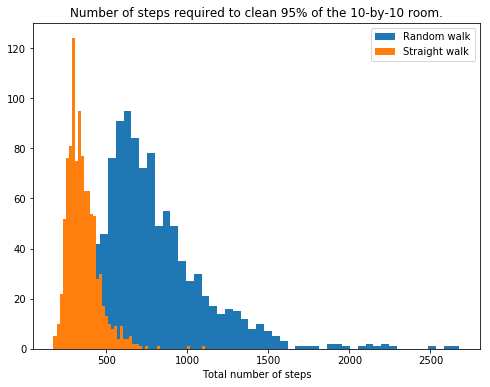

Average number of steps for Random Walk 802.492
Average number of steps for Straight Walk 353.51


In [142]:
plt.figure(figsize=(8, 6))
plt.hist(count_steps_rand, bins=50, label='Random walk')
plt.hist(count_steps_straight, bins=50, label='Straight walk')
plt.title('Number of steps required to clean 95% of the 10-by-10 room.')
plt.xlabel('Total number of steps')
plt.legend()
plt.show()

print('Average number of steps for Random Walk', np.mean(count_steps_rand))
print('Average number of steps for Straight Walk', np.mean(count_steps_straight))

In [141]:
# CI for the mean

# Random walk
standard_error_rand = np.std(count_steps_rand)/np.sqrt(len(count_steps_rand))
lb_rand = np.mean(count_steps_rand)-1.96*standard_error_rand
ub_rand = np.mean(count_steps_rand)+1.96*standard_error_rand

# Straight walk
standard_error_straight = np.std(count_steps_straight)/np.sqrt(len(count_steps_straight))
lb_straight = np.mean(count_steps_straight)-1.96*standard_error_straight
ub_straight = np.mean(count_steps_straight)+1.96*standard_error_straight

print('CI for the mean of the random walk is: ', [np.around(lb_rand,2), np.around(ub_rand,2)])
print('CI for the mean of the straight walk is: ', [np.around(lb_straight,2), np.around(ub_straight,2)])

CI for the mean of the random walk is:  [783.01, 821.97]
CI for the mean of the straight walk is:  [347.47, 359.55]


### Efficiency Measure 2: Wasteful Steps

In [97]:
count_wasteful_rand = []

for x in range(1000):
    r = Room(width=10, length=10)
    r.room_setup()
    
    while r.clean/(r.num_tiles-r.num_items-1) <= 0.95:
        r.random_walk()
    count_wasteful_rand.append((1-r.clean/r.steps))

In [122]:
count_wasteful_straight = []

for x in range(1000):
    r = Room(width=10, length=10, random_switch=optimal_p_switch)
    r.room_setup()
    
    r.pick_direction()
    while r.clean/(r.num_tiles-4) <= 0.95:
        r.straight_walk()
    count_wasteful_straight.append((1-r.clean/r.steps))

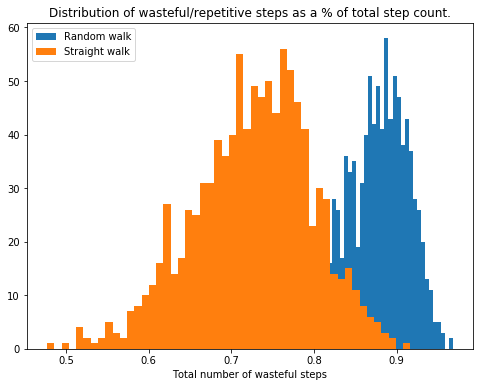

Average for Random Walk 0.872078155504198
Average for Straight Walk 0.7261578559169584


In [130]:
plt.figure(figsize=(8, 6))
plt.hist(count_wasteful_rand, bins=50, label='Random walk')
plt.hist(count_wasteful_straight, bins=50, label='Straight walk')
plt.title('Distribution of wasteful/repetitive steps as a % of total step count.')
plt.xlabel('Total number of wasteful steps')
plt.legend()
plt.show()

print('Average for Random Walk', np.mean(count_wasteful_rand))
print('Average for Straight Walk', np.mean(count_wasteful_straight))

In [144]:
# CI for the mean

# Random walk
standard_error_rand_wasteful = np.std(count_wasteful_rand)/np.sqrt(len(count_wasteful_rand))
lb_rand_wasteful = np.mean(count_wasteful_rand)-1.96*standard_error_rand_wasteful
ub_rand_wasteful = np.mean(count_wasteful_rand)+1.96*standard_error_rand_wasteful

# Straight walk
standard_error_straight_wasteful = np.std(count_wasteful_straight)/np.sqrt(len(count_wasteful_straight))
lb_straight_wasteful = np.mean(count_wasteful_straight)-1.96*standard_error_straight_wasteful
ub_straight_wasteful = np.mean(count_wasteful_straight)+1.96*standard_error_straight_wasteful

print('CI for the mean of the random walk is: ', [np.around(lb_rand_wasteful,3), np.around(ub_rand_wasteful,3)])
print('CI for the mean of the straight walk is: ', [np.around(lb_straight_wasteful,3), np.around(ub_straight_wasteful,3)])

CI for the mean of the random walk is:  [0.869, 0.875]
CI for the mean of the straight walk is:  [0.722, 0.731]


### Optimal number of items in the room

In [109]:
items_count_rand = []
items_all_counts_rand= []
nums_of_items = [0,1,2,3,4,5,6]

for num_items in nums_of_items:
    for x in range(1000):
        r = Room(width=10, length=10, num_items=num_items)
        r.room_setup()

        while r.clean/(r.num_tiles-r.num_items-1) <= 0.70:
            r.random_walk()
        items_count_rand.append((1-r.clean/r.steps))
    items_all_counts_rand.append(np.mean(items_count_rand)) 

In [125]:
items_count_straight = []
items_all_counts_straight= []
nums_of_items = [0,1,2,3,4,5,6]

for num_items in nums_of_items:
    for x in range(1000):
        r = Room(width=10, length=10, num_items=num_items, random_switch=optimal_p_switch)
        r.room_setup()
        
        r.pick_direction()
        while r.clean/(r.num_tiles-r.num_items-1) <= 0.70:
            
            r.straight_walk()
    #     count_straight.append(r.steps)
        items_count_straight.append((1-r.clean/r.steps))
    items_all_counts_straight.append(np.mean(items_count_straight))

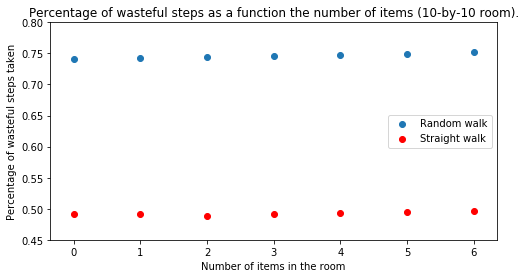

In [137]:
plt.figure(figsize=(8, 4))
plt.title('Percentage of wasteful steps as a function the number of items (10-by-10 room).')

plt.scatter(nums_of_items,items_all_counts_rand,label='Random walk')
plt.scatter(nums_of_items,items_all_counts_straight,label='Straight walk', c='r')
plt.xlabel('Number of items in the room')
plt.ylabel('Percentage of wasteful steps taken')
plt.ylim(0.45,0.8)
plt.legend()
plt.show()

## Animation

This animation is set to display the results of a straight walk strategy.

In [147]:
# Taken from class 12.1 for animation

def make_animation(draw_function, frames, interval, filename=None,
                   verbose=False, figure_params=None):
    """
    Write an animated GIF to file using matplotlib and ImageMagick.

    Inputs:

        draw_function (callable) The function to call, once per frame,
          to render to the current matplotlib figure. This function's call
          signature must be

            draw_function(current_frame_number, total_frame_count)

          The first frame is 0 and the last frame is total_frame_count-1.

        frames (int) The number of frames to generate.

        interval (float) The number of milliseconds to wait between frames
          in the animation. Set this to 40 for a fairly standard frame rate
          of 25fps (1 second / 40 (milliseconds per frame) = 25 frames per
          second).

        filename (str) The path to the file to write to. If none is provided,
          the animation will be written to a random filename, prefixed with
          "animate_" in the current directory. Default: None.

        verbose (bool) Whether to print the current frame number to the
          console as the animation is being created. This will clear other
          console output. Default: False.

        figure_params (dict) The keyword arguments to pass to matplotlib
          when creating a new figure for this animation. Use it to set the
          figure size and other figure properties. Default: None.

    Returns: A display object that will inject HTML for displaying the
      animated GIF into the notebook.
    """
    from matplotlib import pyplot, animation
    from IPython.display import HTML, display, clear_output
    import random

    if filename is None:
        filename = 'animate_%06i.gif' % random.randint(0, 999999)
    # Create figure
    if figure_params is None:
        figure_params = {}
    figure = pyplot.figure(**figure_params)
    # Wrap draw_function if we need to print to console
    if verbose:
        old_draw_function = draw_function
        def draw_function(current_frame_number, total_frame_count):
            old_draw_function(current_frame_number, total_frame_count)
            print('Processed frame', current_frame_number + 1, '/', total_frame_count)
            clear_output(wait=True)
            if current_frame_number + 1 == total_frame_count:
                print('Writing animation to file...')
                clear_output(wait=True)
    # Generate animation
    anim = animation.FuncAnimation(
        figure, draw_function, frames=frames, interval=interval,
        init_func=lambda: None, fargs=(frames,))
    anim.save(filename, writer='imagemagick')
    # Close the animation figure so the last frame does not get displayed
    # in the notebook.
    pyplot.close()
    # Return display object for the animated GIF
#     return display(HTML('<img src="' + filename + '">'))

def gif(frames):
    r = Room(width=10, length=10, random_switch=optimal_p_switch)
    r.room_setup() # dark brown
    r.pick_direction()
    r.show()
    
    def animate(frame, total_frames):
        r.straight_walk()
        r.show()
    animation = make_animation(animate,frames, interval=100000/frames,verbose=True)
    return r.show()

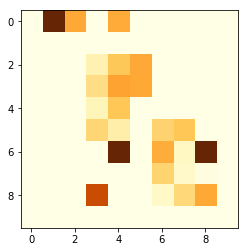

In [149]:
gif(frames=150)